In [1]:
import numpy as np
import pandas as pd
from os.path import join as pjoin
import json
import matplotlib.pyplot as plt
import seaborn as sns

DATA_DIR = "CHANGE_TO_DATA_DIR"

# UNAM THESIS
In this notebook we will analyze the UNAM thesis database that we previously scraped from their website. We will focus on advisors and faculties where the theses were presented.

In [2]:
df = pd.read_csv(pjoin(DATA_DIR, 'resumen_asesores.txt'), 
                sep="\t", 
                header=None,
                dtype=str
                )
df.columns = ["n_tes", "nom", "fechas", "fac"]
df[['primTes', 'ultTes']] = df["fechas"].str.replace('\.','').str.replace(':','').str.split(' ', expand=True)
df = df.drop(["fechas"], axis=1)

/tmp/ipykernel_31311/1820019703.py:7: FutureWarning: The default value of regex will change from True to False in a future version.
  df[['primTes', 'ultTes']] = df["fechas"].str.replace('\.','').str.replace(':','').str.split(' ', expand=True)


In [3]:
# Remove small number of Rows with NaN (~136 rows). Not worth dealing with.
nan_bool = (df.isna().any(axis=1)) | (df['primTes'] == '')
print(f"Number of NaN values:  {sum(nan_bool)}/{df.shape[0]}")
df = df.drop(np.where(nan_bool)[0], axis=0)

Number of NaN values:  193/97623


In [4]:
convert_dict = {'n_tes': int, 'nom': str, 'primTes': int, 'ultTes': int, 'fac': str}
df = df.astype(convert_dict)

### Faculty Names
Now, we translate our faculty information into something that is actually readable. We load the names of the faculties to identify where a particular advisors' students come from. In cases where advisors worked with multiple faculties we simply chose the most frequent one (see bash code).

In [5]:
with open(pjoin(DATA_DIR, 'faculties.json')) as json_file:
    search_words = json.load(json_file)

rename_mask = np.ones(np.shape(df)[0]).astype(bool)
for k in search_words.keys():
    key_bool = df["fac"].str.contains(search_words[k])
    tmp_bool = key_bool * rename_mask
    df.loc[tmp_bool, "fac"] = k
    rename_mask = rename_mask * (~key_bool)
df.loc[df["fac"].str.contains("Maestria"), "fac"] = "Posg."

# Analysis
With the data in a nice format, we can try and look for some interesting results. First, lets look at the 20 advisors with the most thesis.

Some of the names are pretty common, so it's likely that some of them are multiple people. However, names like "Balderas Pedrero, Maria de la Luz" and "Zalapa Rios, Hector Raul" are not so common, so we can assume they are probably one person

In [6]:
df.head(20)
# Asesores con más tesis

,n_tes,nom,fac,primTes,ultTes
0,679,"Navarro Vega, Ignacio Javier",Der.,1968,2017
1,629,"Robles, Francisca",FCPyS,1959,2022
2,538,"Ramirez Dominguez, Jose Antonio",Arqui.,1985,2019
3,500,"Rodriguez Ortiz, Martha",Der.,1983,2019
4,435,"Juarez Rojas, Juan Jesus",Arag.,1986,2021
5,427,"Leon Lopez, Maria Graciela",Arag.,1989,2018
6,412,"Zalapa Rios, Hector Raul",Don Vasco,1995,2021
7,400,"Castellanos Olivares, Antonio",Medic.,1993,2022
8,398,"Balderas Pedrero, Maria de la Luz",ENEO,1998,2022
9,386,"Balseiro Almario, Lasty",ENEO,1986,2022


We can also look at the number of theses advised per year and look for the most productive advisors.

In [7]:
df["tesis/año"] = df["n_tes"] / (df["ultTes"] - df["primTes"] + 1)
df = df.sort_values("tesis/año", ascending=False)[["tesis/año", "n_tes", "nom", "fac", "primTes", "ultTes"]].reset_index(drop=True)
with pd.option_context('display.float_format', '{:0.2f}'.format):
    display(df.head(19))
# Asesores con mayor tesis por año 

,tesis/año,n_tes,nom,fac,primTes,ultTes
0,21.50,43,"Perez y Farias, Jose Manuel",UVM,1992,1993
1,19.22,173,"Miranda Hernandez, Jose Florentino",Der.,1973,1981
2,18.00,18,"Cortes Rangel, Maria Elva",ENEO,2022,2022
3,17.25,276,"Trueba Urbina, Alberto",Der.,1969,1984
4,17.00,17,"Meza Zavala, Leticia",ENEO,2022,2022
5,16.67,50,"Romero Hernandez, David",Arag.,1999,2001
6,16.06,257,"Gandara Cabada, Enrique",Arqui.,2007,2022
7,15.92,398,"Balderas Pedrero, Maria de la Luz",ENEO,1998,2022
8,15.50,124,"Pacheco Hoyos, Nohelia Guadalupe",Esp. Medic.,2015,2022
9,15.50,62,"Martinez Perry, Adela",Sotavento,2019,2022


In [8]:
x1 = sum(df["n_tes"] > 200), sum(df["tesis/año"] > 8)
print(f"Hay {x1[0]} asesores con más de 200 tesis asesoradas")
print(f"Hay {x1[1]} asesores con más de 8 tesis asesoradas por año")

Hay 91 asesores con más de 200 tesis asesoradas
Hay 127 asesores con más de 8 tesis asesoradas por año


Now that we processed the data, we can save it for later use

In [9]:
#df.to_csv(pjoin(DATA_DIR, "asesores_final.csv"))

Let's look at the distribution of the number of theses per advisor. It's clear that both thesis and thesis/year have a power law distribution.

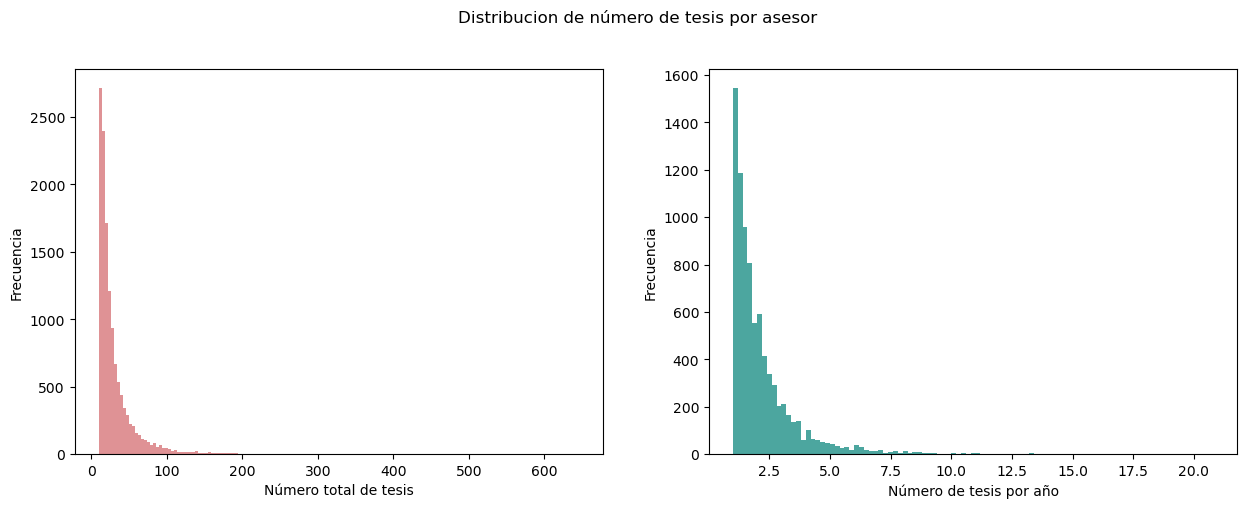

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharey=False)
fig.suptitle('Distribucion de número de tesis por asesor', y=1)

n_tes_min = 10
axs[0].hist(df.loc[df["n_tes"] > n_tes_min, "n_tes"], bins=np.arange(n_tes_min, 650, 4), color='#c1272d', alpha=0.5)
axs[0].set_xlabel("Número total de tesis"); axs[0].set_ylabel("Frecuencia")


axs[1].hist(df.loc[df["n_tes"] > n_tes_min, "tesis/año"], bins=np.arange(1, 21, 0.2), color='#008176', alpha=0.7)
axs[1].set_xlabel("Número de tesis por año"); axs[1].set_ylabel("Frecuencia")


plt.show()

### Faculty Analysis
We analyze the number of advised theses and theses per year in relation to each faculty.

In [11]:
large_facs = list(search_words.keys())[:-10]
df2 = df[df["fac"].isin(large_facs)]

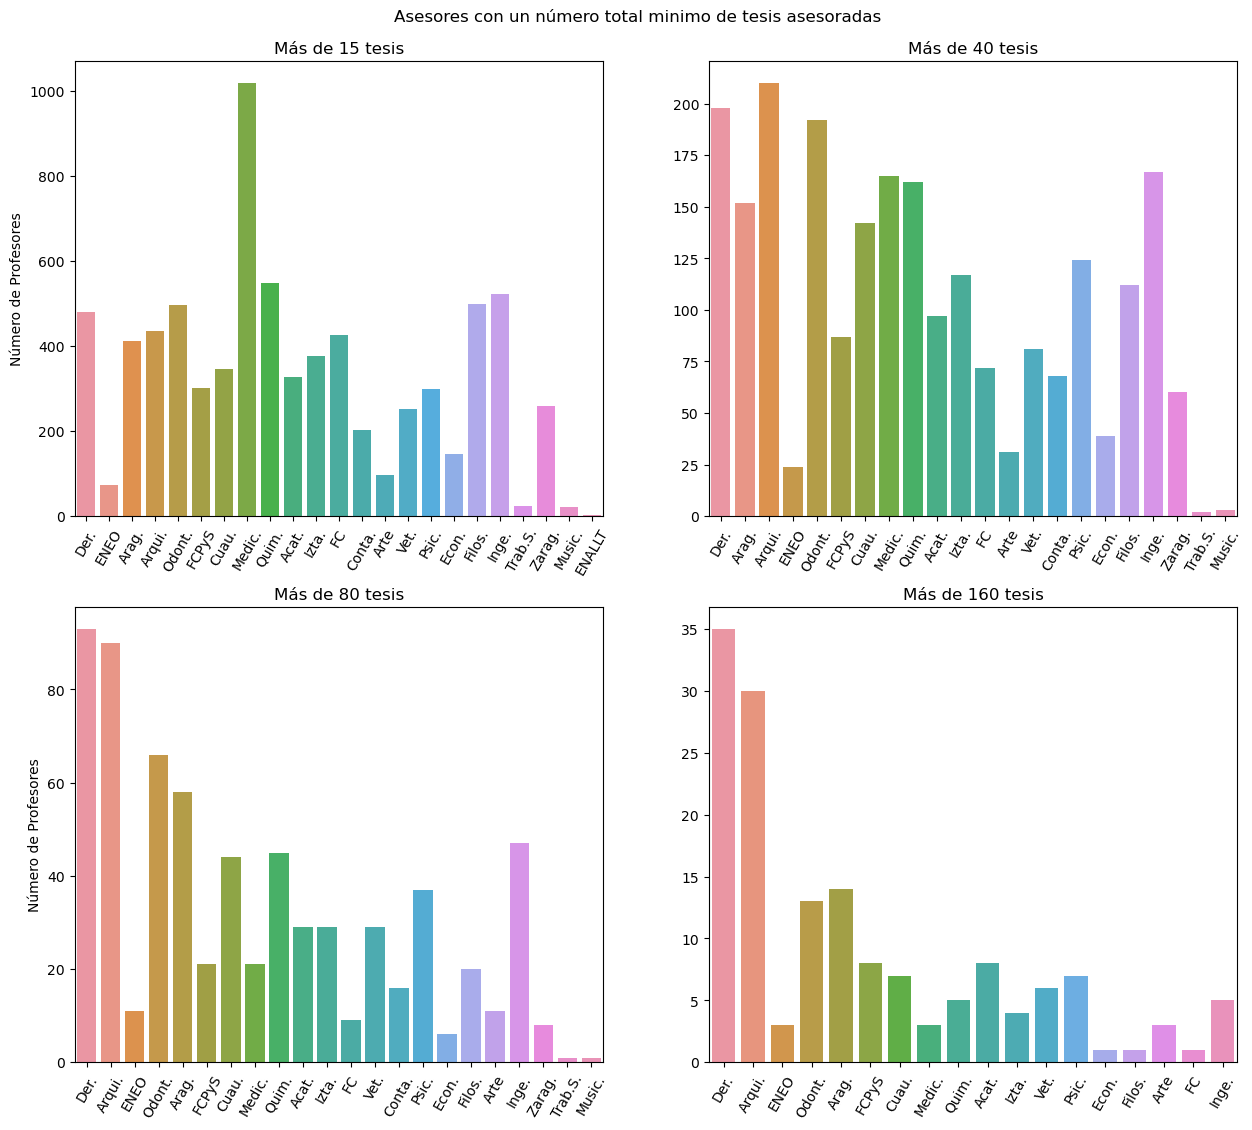

In [12]:
fig, axs = plt.subplots(2, 2, figsize=(15, 13), sharey=False)
fig.suptitle('Asesores con un número total minimo de tesis asesoradas', y=0.92)

for i, k in enumerate([15, 40, 80, 160]):
    chart = sns.countplot(x=df2.loc[df2["n_tes"] > k, "fac"], ax=axs[i // 2, i % 2])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=60, horizontalalignment='center')
    chart.set_ylabel("") if i % 2 == 1 else chart.set_ylabel("Número de Profesores")
    chart.set_xlabel("")
    chart.set_title(f"Más de {k} tesis")

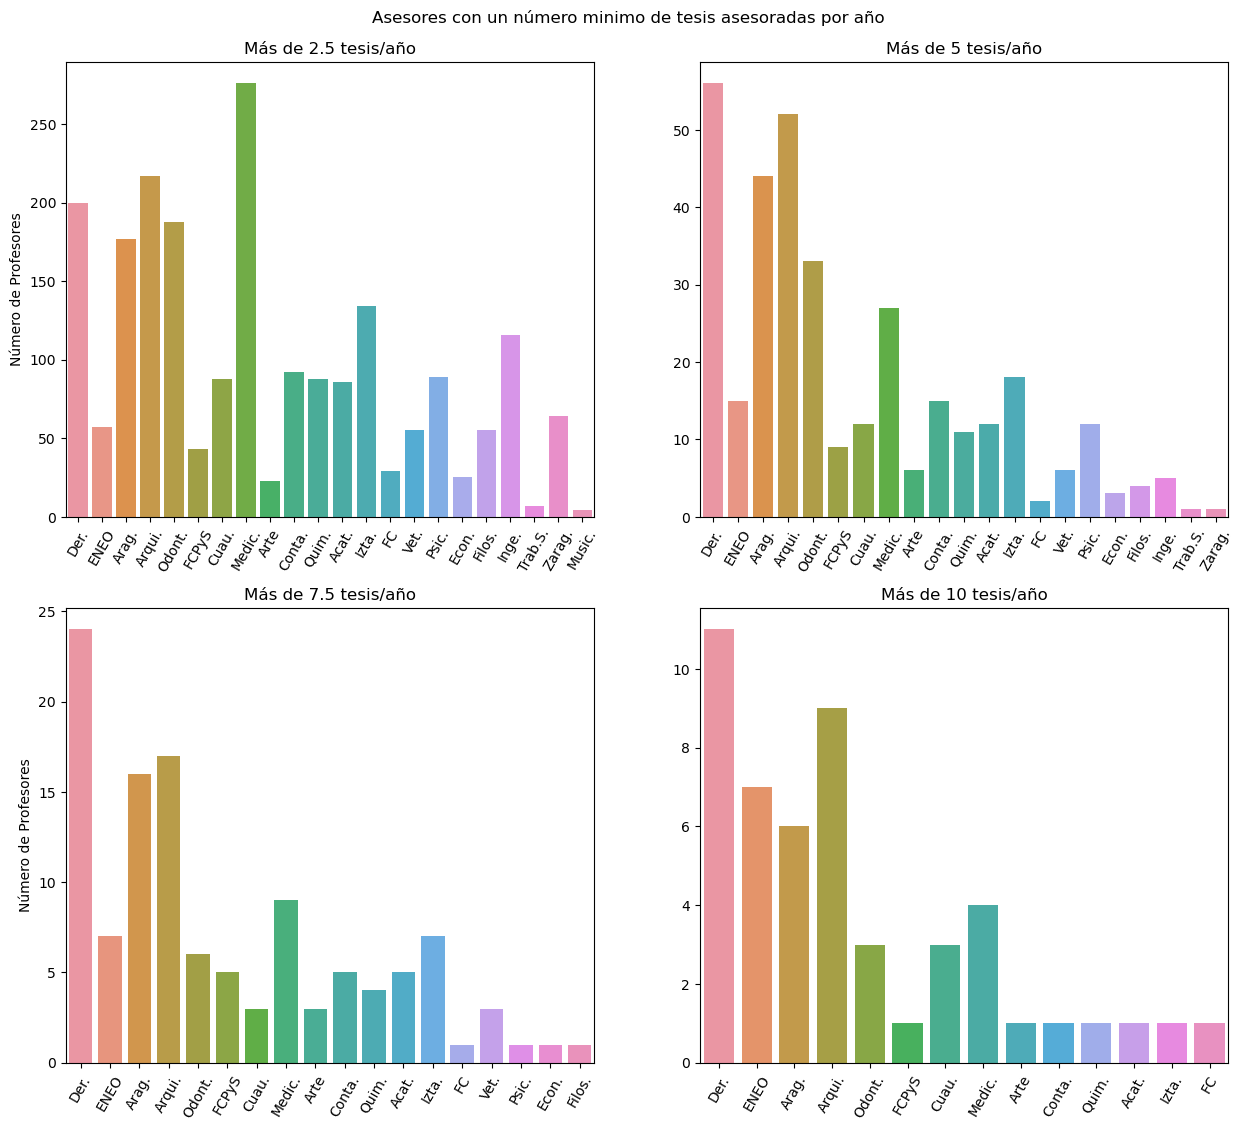

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(15, 13), sharey=False)
fig.suptitle('Asesores con un número minimo de tesis asesoradas por año', y=0.92)

for i, k in enumerate([2.5, 5, 7.5, 10]):
    chart = sns.countplot(x=df2.loc[df2["tesis/año"] > k, "fac"], ax=axs[i // 2, i % 2])
    chart.set_xticklabels(chart.get_xticklabels(), rotation=60, horizontalalignment='center')
    chart.set_ylabel("") if i % 2 == 1 else chart.set_ylabel("Número de Profesores")
    chart.set_xlabel("")
    chart.set_title(f"Más de {k} tesis/año")